# Titanic: Machine Learning from Disaster

[Kaggle competition](https://www.kaggle.com/c/titanic)

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pdp

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score

import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data reading

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [4]:
# pdp.ProfileReport(train_df)
# pdp.ProfileReport(test_df)

# Drop of useless features

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
train_df.drop(['Ticket'], axis=1, inplace=True)
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


In [8]:
test_df.drop(['Ticket'], axis=1, inplace=True)
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,NaN,S


# Functions

In [9]:
def feature_histograms(feature, bins_train=10, bins_test=10, one_line=True):
    """
    Prints feature histograms based on train and test samples
    """
    if one_line:
        fig, ax = plt.subplots(1, 2, figsize=(9, 3))
    else:
        fig, ax = plt.subplots(2, 1, figsize=(7, 6))
        
    train_df[feature].hist(ax=ax[0], bins=bins_train)
    test_df[feature].hist(ax=ax[1], bins=bins_test)
    ax[0].set(title='Train sample', xlabel=feature, ylabel='Frequency')
    ax[1].set(title='Test sample', xlabel=feature, ylabel='Frequency')
    plt.tight_layout()

In [10]:
def feature_countplot(feature, figsize=(4.5, 3)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.countplot(x=feature, hue='Survived', data=train_df, ax=ax)
    plt.tight_layout()

    
def feature_boxplot(feature, figsize=(4.5, 3)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(x='Survived', y=feature, data=train_df, ax=ax)
    plt.tight_layout()

In [11]:
def survived_percentage(feature, value):
    """
    Returns (survived people with feature == value) / (all people with feature == value) * 100%
    """
    survived_count = len(train_df[(train_df[feature] == value) & (train_df['Survived'] == 1)])
    full_count = len(train_df[(train_df[feature] == value)])
    return (round(survived_count / full_count * 100, 2))


def feature_and_survival_corr(feature):
    """
    Prints(survived_percentage) for every value of a discrete feature
    """
    feature_series = train_df[feature].copy()
    feature_series.dropna(inplace=True)
    feature_values = feature_series.unique()

    survived_proportion = [survived_percentage(feature, value) for value in feature_values]
    
    indices = [' '] * len(feature_values)
    df = pd.DataFrame({feature: feature_values, 'Survived proportion, %': survived_proportion}, index=indices)
    df = df[[feature, 'Survived proportion, %']]
    
    df.sort_values('Survived proportion, %', ascending=False, inplace=True)
    
    return df

# Survived

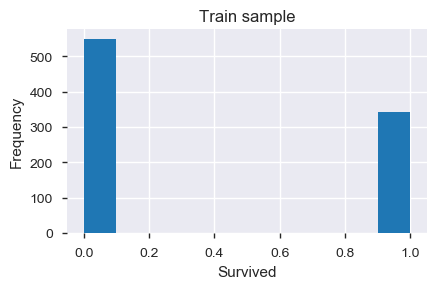

In [12]:
fig, ax = plt.subplots(figsize=(4.5, 3))
train_df['Survived'].hist(ax=ax)
ax.set(title='Train sample', xlabel='Survived', ylabel='Frequency')
plt.tight_layout()

In [13]:
for index, value in train_df['Survived'].value_counts(normalize=False).iteritems():
        print('Survived: {} - {} passengers'.format(index, value))
print()
for index, value in train_df['Survived'].value_counts(normalize=True).iteritems():
        print('Survived: {} - {}%'.format(index, round(value * 100, 2)))

Survived: 0 - 549 passengers
Survived: 1 - 342 passengers

Survived: 0 - 61.62%
Survived: 1 - 38.38%


# Cabin

### Filling of NaNs

In [14]:
train_df['Cabin'] = train_df['Cabin'].apply(lambda cabin: 'Filled' if type(cabin) == str else 'Missed')
test_df['Cabin'] = test_df['Cabin'].apply(lambda cabin: 'Filled' if type(cabin) == str else 'Missed')

### Train and test samples

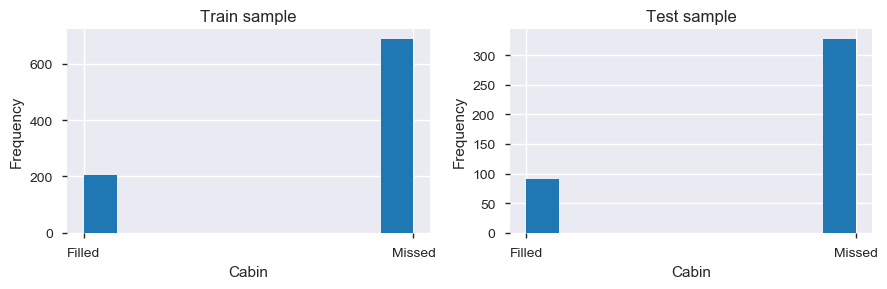

In [15]:
feature_histograms('Cabin')

***Train and test samples have a similar distribution.***

### Correlation with Survival

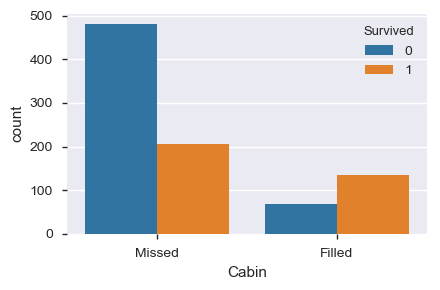

In [16]:
feature_countplot('Cabin')

In [17]:
feature_and_survival_corr('Cabin')

,Cabin,"Survived proportion, %"
,Filled,66.67
,Missed,29.99


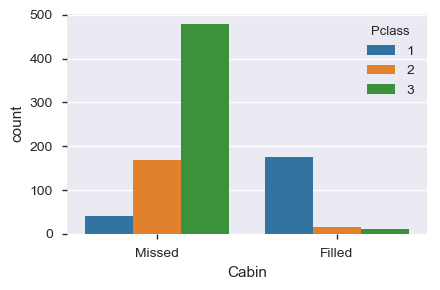

In [18]:
fig, ax = plt.subplots(figsize=(4.5, 3))
sns.countplot(x='Cabin', hue='Pclass', data=train_df, ax=ax)
plt.tight_layout()

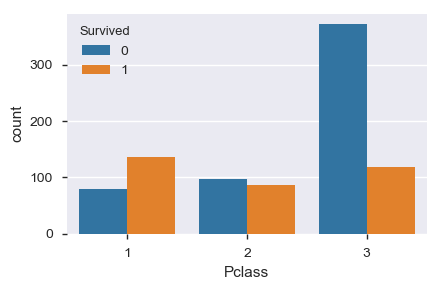

In [19]:
feature_countplot('Pclass')

In [20]:
feature_and_survival_corr('Pclass')

,Pclass,"Survived proportion, %"
,1,62.96
,2,47.28
,3,24.24


***Passengers with cabin filled class distribution (only for train sample):***

In [21]:
for index, value in train_df[(train_df['Cabin'] == 'Filled')]\
                                        ['Pclass'].value_counts(normalize=True).iteritems():
        print('{} class - {}%'.format(index, round(value * 100, 2)))

1 class - 86.27%
2 class - 7.84%
3 class - 5.88%


***86 % of passengers with a cabin filled were from the 1 class. This explains the phenomenon of high survival rate among the filled cabin people.***

***Passengers with cabin filled samples distribution:***

In [22]:
for sample_name, df in zip(['Train', 'Test'], [train_df, test_df]):
    percentage = len(df[(df['Cabin'] == 'Filled')]) / len(df)
    print('{} sample - {}%'.format(sample_name, round(percentage * 100, 2)))

Train sample - 22.9%
Test sample - 21.77%


***Due to the large number of missing values, it is not possible to use this feature.***

In [23]:
train_df.drop(['Cabin'], axis=1, inplace=True)
test_df.drop(['Cabin'], axis=1, inplace=True)

# Pclass

### Train and test samples

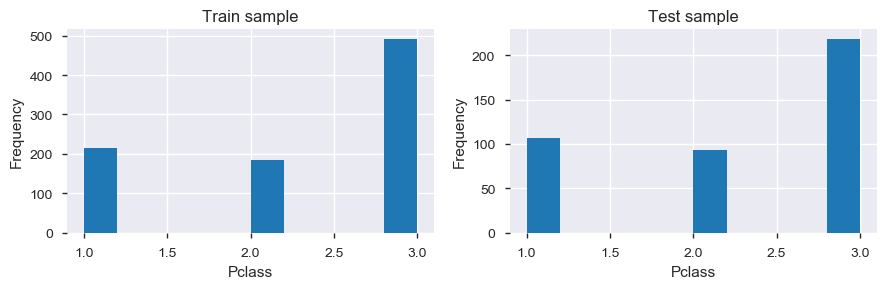

In [24]:
feature_histograms('Pclass')

***Train and test samples have a similar distribution.***

### Correlation with Survival

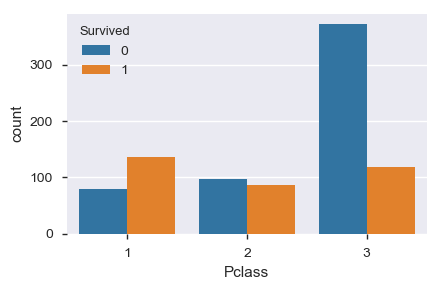

In [25]:
feature_countplot('Pclass')

In [26]:
feature_and_survival_corr('Pclass')

,Pclass,"Survived proportion, %"
,1,62.96
,2,47.28
,3,24.24


In [27]:
train_df.corr().at['Survived', 'Pclass']

-0.33848103596101586

***There is a medium correlation between Pclass and Survived features.***

# Name and Title

### Title parsing

In [28]:
def title_parsing(row):
    """
    person_name = 'Wilkes, Mrs. James (Ellen Needs)'
    parse_title(person_name) == 'Mrs'
    """
    name = row['Name']
    return (name.split(',')[1].split('.')[0].strip())

In [29]:
train_df['Title'] = train_df.apply(title_parsing, axis=1)
test_df['Title'] = test_df.apply(title_parsing, axis=1)

full_df = pd.concat([train_df, test_df], axis=0)
full_df['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
the Countess      1
Capt              1
Jonkheer          1
Dona              1
Sir               1
Mme               1
Don               1
Name: Title, dtype: int64

### Mr, Master, Miss, Mrs

In [30]:
mr_df = full_df[full_df['Title'] == 'Mr']
master_df = full_df[full_df['Title'] == 'Master']
miss_df = full_df[full_df['Title'] == 'Miss']
mrs_df = full_df[full_df['Title'] == 'Mrs']

print((mr_df['Sex'] == 'female').any())
print((master_df['Sex'] == 'female').any())
print((miss_df['Sex'] == 'male').any())
print((mrs_df['Sex'] == 'male').any())

False
False
False
False


***There is no conflicts between Title and Sex features***

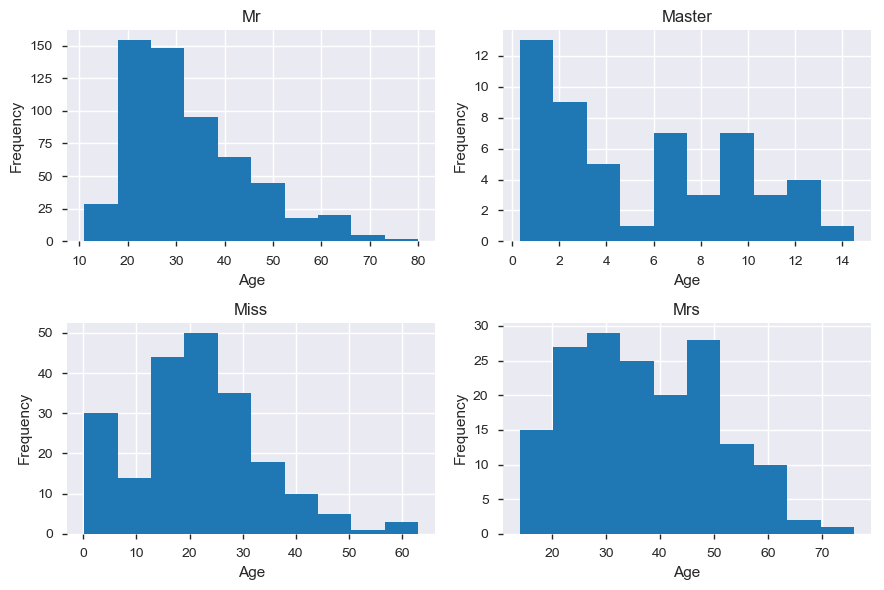

In [31]:
dataframes = [mr_df, master_df, miss_df, mrs_df]
popular_titles = ['Mr', 'Master', 'Miss', 'Mrs']

fig = plt.figure(figsize=(9, 6))
for i, df, title in zip(range(1, 5), dataframes, popular_titles):
    ax = fig.add_subplot(2, 2, i)
    df['Age'].hist(ax=ax)
    ax.set(title=title, xlabel='Age', ylabel='Frequency')
    
plt.tight_layout()

### Other titles - overview

In [32]:
other_titles_df = full_df[~full_df['Title'].isin(popular_titles)]
pd.set_option('max_colwidth', 70)
other_titles_df.sort_values(by=['Sex', 'Age'], ascending=[True, True])

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title
369,24.0,C,69.3000,"Aubart, Mme. Leontine Pauline",0,370,1,female,0,1.0,Mme
641,24.0,C,69.3000,"Sagesser, Mlle. Emma",0,642,1,female,0,1.0,Mlle
710,24.0,C,49.5042,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",0,711,1,female,0,1.0,Mlle
443,28.0,S,13.0000,"Reynaldo, Ms. Encarnacion",0,444,2,female,0,1.0,Ms
759,33.0,S,86.5000,"Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)",0,760,1,female,0,1.0,the Countess
414,39.0,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,Dona
556,48.0,C,39.6000,"Duff Gordon, Lady. (Lucille Christiana Sutherland) (""Mrs Morgan"")",0,557,1,female,1,1.0,Lady
796,49.0,S,25.9292,"Leader, Dr. Alice (Farnham)",0,797,1,female,0,1.0,Dr
88,NaN,Q,7.7500,"O'Donoghue, Ms. Bridget",0,980,3,female,0,NaN,Ms
398,23.0,S,10.5000,"Pain, Dr. Alfred",0,399,2,male,0,0.0,Dr


In [33]:
other_titles_df[other_titles_df['Sex'] == 'female']['Title'].value_counts()

Ms              2
Mlle            2
the Countess    1
Lady            1
Mme             1
Dr              1
Dona            1
Name: Title, dtype: int64

In [34]:
other_titles_df[other_titles_df['Sex'] == 'male']['Title'].value_counts()

Rev         8
Dr          7
Col         4
Major       2
Jonkheer    1
Sir         1
Capt        1
Don         1
Name: Title, dtype: int64

### Other titles - replacement

***Popular titles:***

Adult male: Mr

Young male: Master

Single female: Miss

Married female: Mrs

***Other titles:***

Rev, Dr (male), Col, Major, Jonkheer, Capt, Sir, Don are replaced by Mr

Mlle are replaced by Miss

Mme are replaced by Mrs

Lady, Dr (female), Ms, Dona, the Countess are replaced by Miss or Mrs

In [35]:
print(miss_df['Age'].mean())
print(miss_df['Age'].median())
print(mrs_df['Age'].mean())
print(mrs_df['Age'].median())

21.774238095238097
22.0
36.99411764705882
35.5


In [36]:
def title_replacement(row):
    """
    If title in the row is popular returns it
    Else for unpopular title returns the appropriate popular title
    """
    title = row['Title']
    if title in popular_titles:
        return title
    else:
        if title in ['Rev', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don']:
            return 'Mr'
        elif title == 'Dr' and row['Sex'] == 'male':
            return 'Mr'
        elif title == 'Mlle':
            return 'Miss'
        elif title == 'Mme':
            return 'Mrs'
        elif not row['Age']:
            return 'Mrs'
        else:
            miss_median = miss_df['Age'].median()
            mrs_median = mrs_df['Age'].median()
            
            if abs(row['Age'] - miss_median) < abs(row['Age'] - mrs_median):
                return 'Miss'
            else:
                return 'Mrs'

In [37]:
train_df['Title'] = train_df.apply(title_replacement, axis=1)
test_df['Title'] = test_df.apply(title_replacement, axis=1)

In [38]:
train_df.drop(['Name'], axis=1, inplace=True)
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,male,22.0,1,0,7.2500,S,Mr
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs
2,3,1,3,female,26.0,0,0,7.9250,S,Miss
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs
4,5,0,3,male,35.0,0,0,8.0500,S,Mr


In [39]:
test_df.drop(['Name'], axis=1, inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,male,34.5,0,0,7.8292,Q,Mr
1,893,3,female,47.0,1,0,7.0000,S,Mrs
2,894,2,male,62.0,0,0,9.6875,Q,Mr
3,895,3,male,27.0,0,0,8.6625,S,Mr
4,896,3,female,22.0,1,1,12.2875,S,Mrs


### Train and test samples

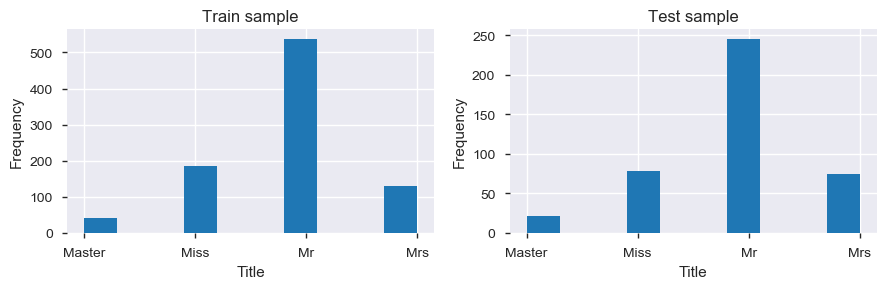

In [40]:
feature_histograms('Title')

***Train and test samples have a similar distribution.***

### Correlation with Survival

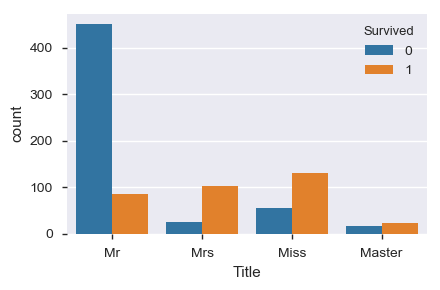

In [41]:
feature_countplot('Title')

In [42]:
feature_and_survival_corr('Title')

,Title,"Survived proportion, %"
,Mrs,79.84
,Miss,70.27
,Master,57.50
,Mr,16.01


***Most likely there is a strong correlation between Title and Survived features.***

# Title_Pclass

In [43]:
def title_pclass(row): return row['Title'] + str(row['Pclass'])

train_df['Title_Pclass'] = train_df.apply(title_pclass, axis=1)
test_df['Title_Pclass'] = test_df.apply(title_pclass, axis=1)

### Train and test samples

In [44]:
print(sorted(train_df['Title_Pclass'].unique()))
print(sorted(test_df['Title_Pclass'].unique()))

['Master1', 'Master2', 'Master3', 'Miss1', 'Miss2', 'Miss3', 'Mr1', 'Mr2', 'Mr3', 'Mrs1', 'Mrs2', 'Mrs3']
['Master1', 'Master2', 'Master3', 'Miss1', 'Miss2', 'Miss3', 'Mr1', 'Mr2', 'Mr3', 'Mrs1', 'Mrs2', 'Mrs3']


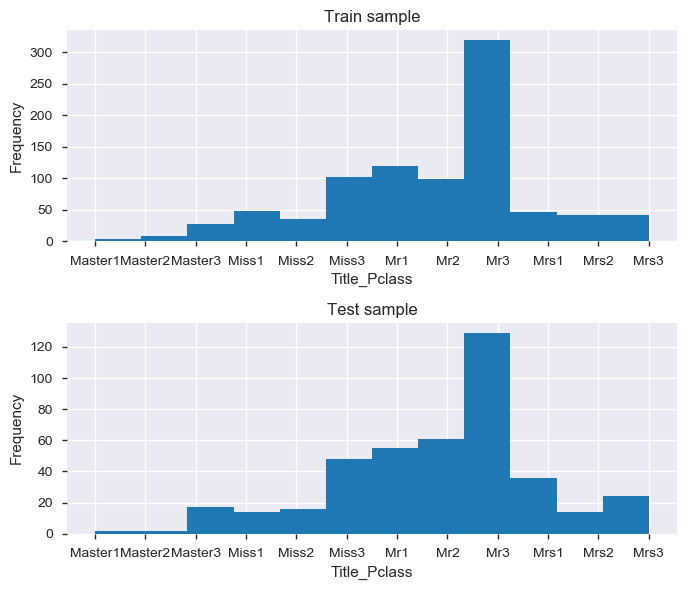

In [45]:
feature_histograms('Title_Pclass', bins_train=12, bins_test=12, one_line=False)

***Train and test samples have a similar distribution.***

### Correlation with Survival

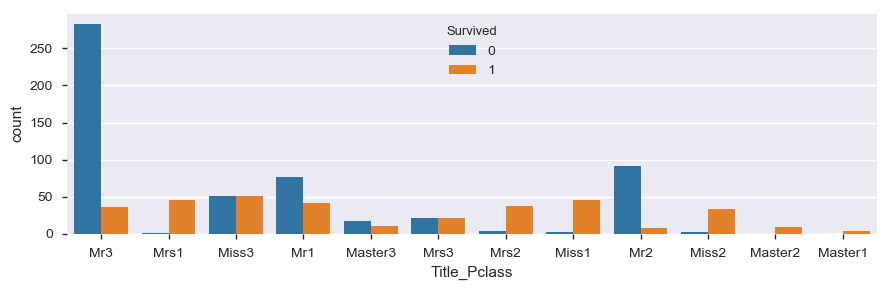

In [46]:
feature_countplot('Title_Pclass', figsize=(9, 3))

In [47]:
feature_and_survival_corr('Title_Pclass')

,Title_Pclass,"Survived proportion, %"
,Master2,100.00
,Master1,100.00
,Mrs1,97.83
,Miss1,95.83
,Miss2,94.29
,Mrs2,90.24
,Miss3,50.00
,Mrs3,50.00
,Master3,39.29
,Mr1,35.29


***Most likely there is a very strong correlation between Title_Pclass and Survived features.***

# Sex

### Train and test samples

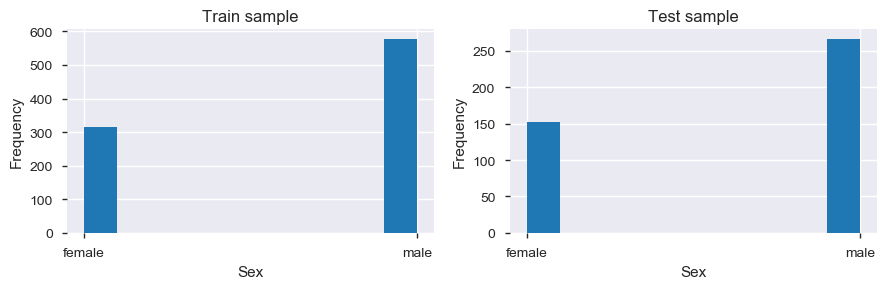

In [48]:
feature_histograms('Sex')

***Train and test samples have a similar distribution.***

### Correlation with Survival

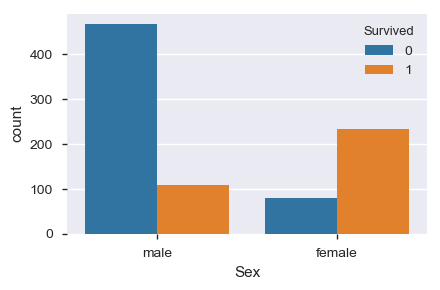

In [49]:
feature_countplot('Sex')

In [50]:
feature_and_survival_corr('Sex')

,Sex,"Survived proportion, %"
,female,74.20
,male,18.89


***Most likely there is a strong correlation between Sex and Survived features.***

# SibSp

### Train and test samples

In [51]:
print(sorted(train_df['SibSp'].unique()))
print(sorted(test_df['SibSp'].unique()))

[0, 1, 2, 3, 4, 5, 8]
[0, 1, 2, 3, 4, 5, 8]


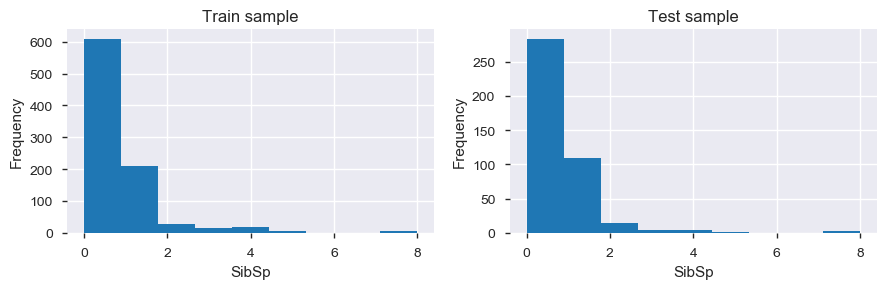

In [52]:
feature_histograms('SibSp', bins_train=9, bins_test=9)

***Train and test samples have a similar distribution.***

### Correlation with Survival

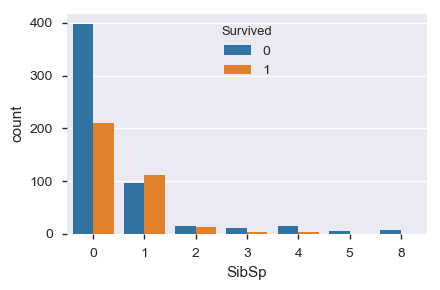

In [53]:
feature_countplot('SibSp')

In [54]:
feature_and_survival_corr('SibSp')

,SibSp,"Survived proportion, %"
,1,53.59
,2,46.43
,0,34.54
,3,25.00
,4,16.67
,5,0.00
,8,0.00


In [55]:
train_df.corr().at['Survived', 'SibSp']

-0.035322498885735881

***There is a very small correlation between SibSp and Survived features.***

# Parch

### Train and test samples

In [56]:
print(sorted(train_df['Parch'].unique()))
print(sorted(test_df['Parch'].unique()))

[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 9]


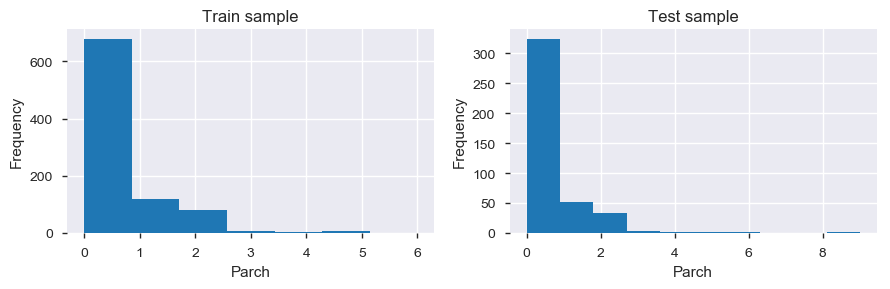

In [57]:
feature_histograms('Parch', bins_train=7, bins_test=10)

***Train and test samples have a similar distribution.***

### Correlation with Survival

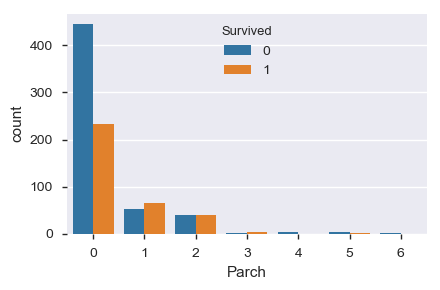

In [58]:
feature_countplot('Parch')

In [59]:
feature_and_survival_corr('Parch')

,Parch,"Survived proportion, %"
,3,60.00
,1,55.08
,2,50.00
,0,34.37
,5,20.00
,4,0.00
,6,0.00


In [60]:
train_df.corr().at['Survived', 'Parch']

0.081629407083482222

***There is a small correlation between Parch and Survived features.***

# Relatives

In [61]:
def relatives_count(row): return row['SibSp'] + row['Parch']

train_df['Relatives'] = train_df.apply(relatives_count, axis=1)
test_df['Relatives'] = test_df.apply(relatives_count, axis=1)

### Train and test samples

In [62]:
print(sorted(train_df['Relatives'].unique()))
print(sorted(test_df['Relatives'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 10]
[0, 1, 2, 3, 4, 5, 6, 7, 10]


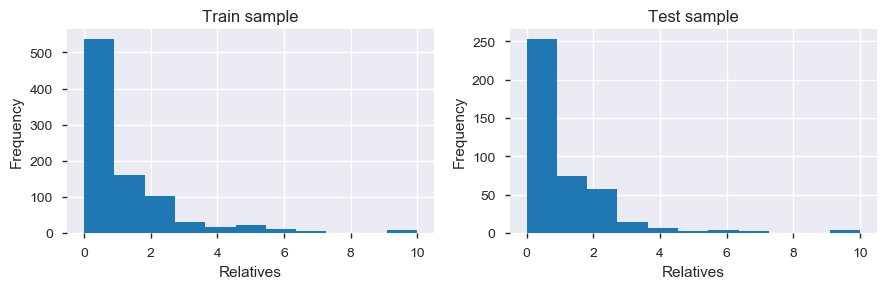

In [63]:
feature_histograms('Relatives', bins_train=11, bins_test=11)

***Train and test samples have a similar distribution.***

### Correlation with Survival

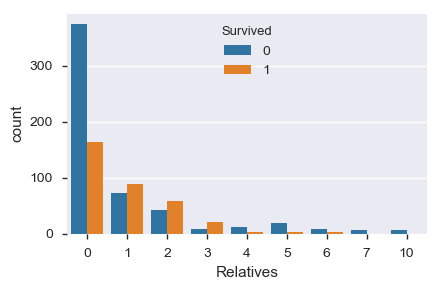

In [64]:
feature_countplot('Relatives')

In [65]:
feature_and_survival_corr('Relatives')

,Relatives,"Survived proportion, %"
,3,72.41
,2,57.84
,1,55.28
,6,33.33
,0,30.35
,4,20.00
,5,13.64
,7,0.00
,10,0.00


In [66]:
train_df.corr().at['Survived', 'Relatives']

0.01663898928274531

***There is an almost zero correlation between Relatives and Survived features.***

# Fare

### Train and test samples

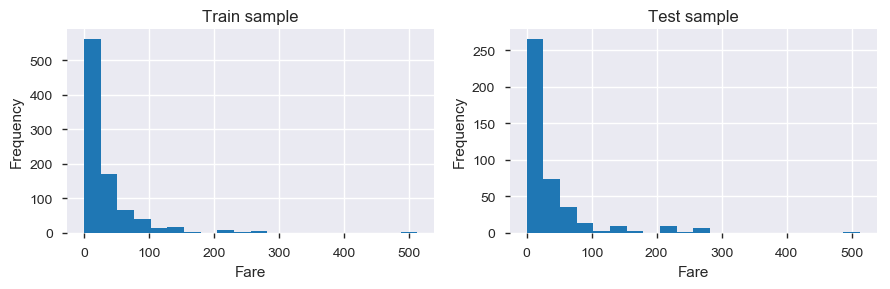

In [67]:
feature_histograms('Fare', bins_train=20, bins_test=20)

***Train and test samples have a similar distribution.***

***Feature distribution is not normal. To make the distribution more similar to normal, logarithm(Fare) is used.***

In [68]:
train_df['Fare_log'] = train_df['Fare'].apply(lambda fare: round(np.log2(fare + 1), 2))
test_df['Fare_log'] = test_df['Fare'].apply(lambda fare: round(np.log2(fare + 1), 2))

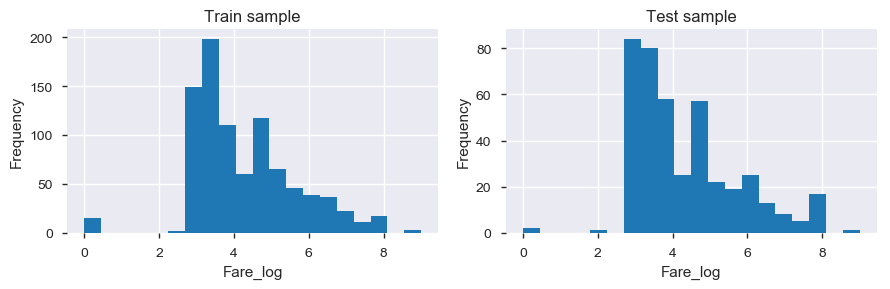

In [69]:
feature_histograms('Fare_log', bins_train=20, bins_test=20)

### Correlation with Survival

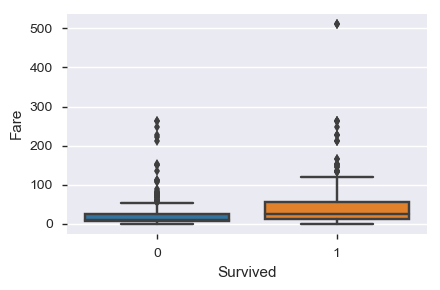

In [70]:
feature_boxplot('Fare')

In [71]:
train_df.corr().at['Survived', 'Fare']

0.25730652238496182

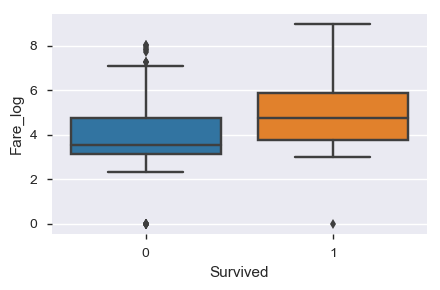

In [72]:
feature_boxplot('Fare_log')

In [73]:
train_df.corr().at['Survived', 'Fare_log']

0.32998117101123625

***There is a medium correlation between Fare_log and Survived features.***

In [74]:
train_df.drop(['Fare'], axis=1, inplace=True)
test_df.drop(['Fare'], axis=1, inplace=True)

In [75]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,Title_Pclass,Relatives,Fare_log
0,1,0,3,male,22.0,1,0,S,Mr,Mr3,1,3.04
1,2,1,1,female,38.0,1,0,C,Mrs,Mrs1,1,6.18
2,3,1,3,female,26.0,0,0,S,Miss,Miss3,0,3.16
3,4,1,1,female,35.0,1,0,S,Mrs,Mrs1,1,5.76
4,5,0,3,male,35.0,0,0,S,Mr,Mr3,0,3.18


In [76]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,Title_Pclass,Relatives,Fare_log
0,892,3,male,34.5,0,0,Q,Mr,Mr3,0,3.14
1,893,3,female,47.0,1,0,S,Mrs,Mrs3,1,3.00
2,894,2,male,62.0,0,0,Q,Mr,Mr2,0,3.42
3,895,3,male,27.0,0,0,S,Mr,Mr3,0,3.27
4,896,3,female,22.0,1,1,S,Mrs,Mrs3,2,3.73


### Filling of NaNs

In [77]:
train_df.isnull().any()

PassengerId     False
Survived        False
Pclass          False
Sex             False
Age              True
SibSp           False
Parch           False
Embarked         True
Title           False
Title_Pclass    False
Relatives       False
Fare_log        False
dtype: bool

In [78]:
test_df.isnull().any()

PassengerId     False
Pclass          False
Sex             False
Age              True
SibSp           False
Parch           False
Embarked        False
Title           False
Title_Pclass    False
Relatives       False
Fare_log         True
dtype: bool

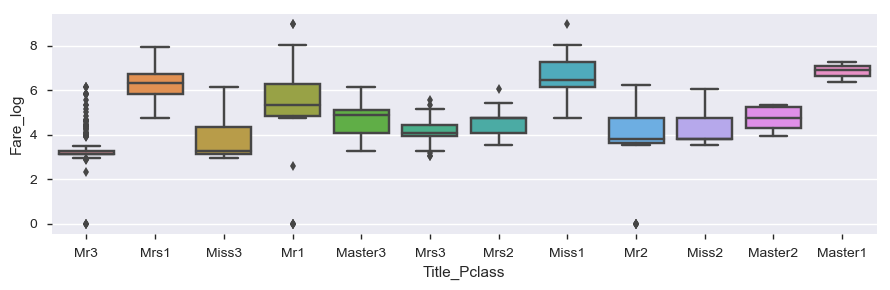

In [79]:
fig, ax = plt.subplots(figsize=(9,3))
sns.boxplot(x='Title_Pclass', y='Fare_log', data=train_df, ax=ax)
plt.tight_layout()

***The median of each class is used for filling missed values.***

In [80]:
full_df = pd.concat([train_df, test_df], axis=0)
fare_medians = {title_pclass: df['Fare_log'].median() for title_pclass, df in full_df.groupby('Title_Pclass')}
print(fare_medians)

{'Master1': 7.08, 'Master2': 4.75, 'Master3': 4.55, 'Miss1': 6.654999999999999, 'Miss2': 4.36, 'Miss3': 3.18, 'Mr1': 5.5649999999999995, 'Mr2': 3.81, 'Mr3': 3.15, 'Mrs1': 6.305, 'Mrs2': 4.75, 'Mrs3': 4.04}


In [81]:
def fare_replacement(row):
    """
    If Fare in the row is not NaN returns it
    Else returns fare median for current Title_Pclass
    """
    fare = row['Fare_log']
    if not np.isnan(fare):
        return fare
    else:
        return fare_medians[row['Title_Pclass']]

In [82]:
test_df['Fare_log'] = test_df.apply(fare_replacement, axis=1)

In [83]:
test_df.isnull().any()

PassengerId     False
Pclass          False
Sex             False
Age              True
SibSp           False
Parch           False
Embarked        False
Title           False
Title_Pclass    False
Relatives       False
Fare_log        False
dtype: bool

# Embarked

### Train and test samples

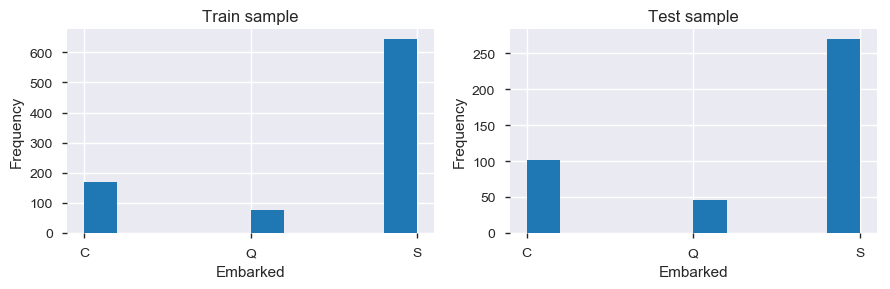

In [84]:
feature_histograms('Embarked')

***Train and test samples have a similar distribution.***

### Correlation with Survival

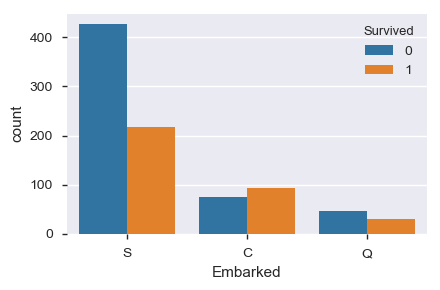

In [85]:
feature_countplot('Embarked')

In [86]:
feature_and_survival_corr('Embarked')

,Embarked,"Survived proportion, %"
,C,55.36
,Q,38.96
,S,33.70


***Most likely there is a small correlation between Embarked and Survived features.***

### Filling of NaNs

In [87]:
full_df = pd.concat([train_df, test_df], axis=0)
print(full_df['Embarked'].value_counts(), '\n')
print('The mode of Embarked: {}'.format(full_df['Embarked'].mode()[0]))

S    914
C    270
Q    123
Name: Embarked, dtype: int64 

The mode of Embarked: S


***Southampton is the most frequent port of embarkation, hence 'S' is used for filling missed values.***

In [92]:
values = {'Embarked': full_df['Embarked'].mode()[0]}
train_df.fillna(value=values, inplace=True)
train_df['Embarked'].isnull().any()

False

In [93]:
train_df.isnull().any()

PassengerId     False
Survived        False
Pclass          False
Sex             False
Age              True
SibSp           False
Parch           False
Embarked        False
Title           False
Title_Pclass    False
Relatives       False
Fare_log        False
dtype: bool

# Age

### Train and test samples

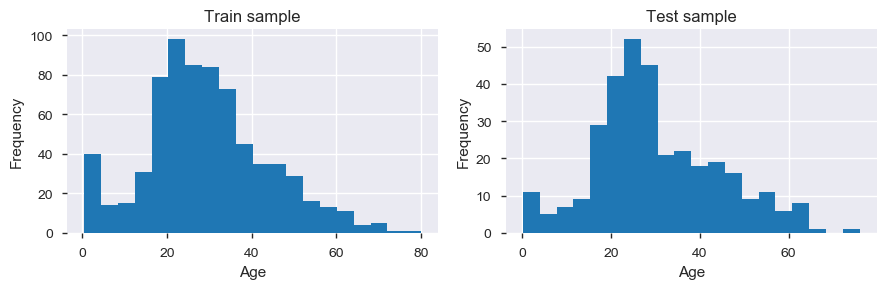

In [94]:
feature_histograms('Age', bins_train=20, bins_test=20)

***Train and test samples have a similar distribution.***

### Correlation with Survival

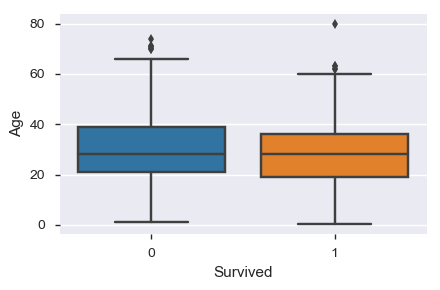

In [95]:
feature_boxplot('Age')

In [96]:
train_df.corr().at['Survived', 'Age']

-0.077221094572177365

***There is a small correlation between Age and Survived features.***

### Filling of NaNs

In [97]:
full_df = pd.concat([train_df, test_df], axis=0)
full_df.drop(['PassengerId', 'Survived', 'Title_Pclass'], axis=1, inplace=True)
full_df = pd.get_dummies(full_df)

X_train = full_df[full_df['Age'].notnull()].drop(['Age'], axis=1, inplace=False)
y_train = full_df[full_df['Age'].notnull()]['Age']

print(X_train.shape)
print(y_train.shape)

(1046, 14)
(1046,)


In [98]:
X_train.head()

,Fare_log,Parch,Pclass,Relatives,SibSp,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,3.04,0,3,1,1,0,0,1,0,1,0,0,1,0
1,6.18,0,1,1,1,1,0,0,1,0,0,0,0,1
2,3.16,0,3,0,0,0,0,1,1,0,0,1,0,0
3,5.76,0,1,1,1,0,0,1,1,0,0,0,0,1
4,3.18,0,3,0,0,0,0,1,0,1,0,0,1,0


In [99]:
# param_dist = {'criterion': ('mse', 'mae'),
#               'max_features': list(range(2, 15, 1)),
#               'max_depth': list(range(1, 12, 1)),
#               'min_samples_split': list(range(2, 20, 1)),
#               'min_samples_leaf': list(range(1, 8, 1))}

# best_forest = RandomizedSearchCV(RandomForestRegressor(n_estimators=100, random_state=42),
#                            param_distributions=param_dist, n_jobs=-1, cv=5, verbose=1)

In [100]:
# best_forest.fit(X_train, y_train)
# print(best_forest.best_params_)
# print(best_forest.best_score_)
# print(best_forest.best_estimator_.oob_score_)

In [101]:
fixed_params = {'min_samples_split': 3,
               'min_samples_leaf': 3,
               'max_features': 3,
               'max_depth': 8,
               'criterion': 'mae'}

random_forest = RandomForestRegressor(n_estimators=1000, random_state=42, **fixed_params)
random_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=8,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [102]:
def feature_importances_output(importances, features):
    importances_seris = pd.Series(importances, index=features)
    importances_seris.sort_values(ascending=False, inplace=True)
    return importances_seris

In [103]:
feature_importances_output(random_forest.feature_importances_, X_train.columns)

Pclass          0.189647
Fare_log        0.172305
Title_Master    0.162294
Title_Miss      0.088057
Parch           0.081503
SibSp           0.075554
Relatives       0.068757
Title_Mrs       0.049183
Title_Mr        0.043480
Sex_female      0.019733
Sex_male        0.018213
Embarked_C      0.013722
Embarked_S      0.011131
Embarked_Q      0.004422
dtype: float64

In [104]:
def age_replacement(row):
    """
    If Age in the row is not NaN returns it
    Else predicts the Age value and returns it
    """
    age = row['Age']
    if not np.isnan(age):
        return age
    else:
        row.drop(['Age'], inplace=True)
        row = row.values.reshape(1, len(row))
        return round(random_forest.predict(row)[0], 2)

In [105]:
full_df['Age'] = full_df.apply(age_replacement, axis=1)
train_df['Age'] = full_df['Age'][:len(train_df)].copy()
test_df['Age'] = full_df['Age'][len(train_df):].copy()

In [106]:
print(train_df.isnull().any().any())
print(test_df.isnull().any().any())

False
False


# 1. Gender decision rule

In [107]:
def gender_decision_rule(row):
    if row['Sex'] == 'male':
        return 0
    else:
        return 1

In [108]:
def make_submission(y_pred, file_name):
    submission = pd.DataFrame({'PassengerId': list(range(892, 1310)), 'Survived': [int(i) for i in y_pred]})
    submission.to_csv(file_name, index=False)

In [109]:
y_pred = test_df.apply(gender_decision_rule, axis=1)
make_submission(y_pred, 'answers/answers1_gender_decision_rule.csv')

### Kagle accuracy score: 0.76555

# 2. Simple decision rule

### Features analysis

In [110]:
feature_and_survival_corr('Title_Pclass')

,Title_Pclass,"Survived proportion, %"
,Master2,100.00
,Master1,100.00
,Mrs1,97.83
,Miss1,95.83
,Miss2,94.29
,Mrs2,90.24
,Miss3,50.00
,Mrs3,50.00
,Master3,39.29
,Mr1,35.29


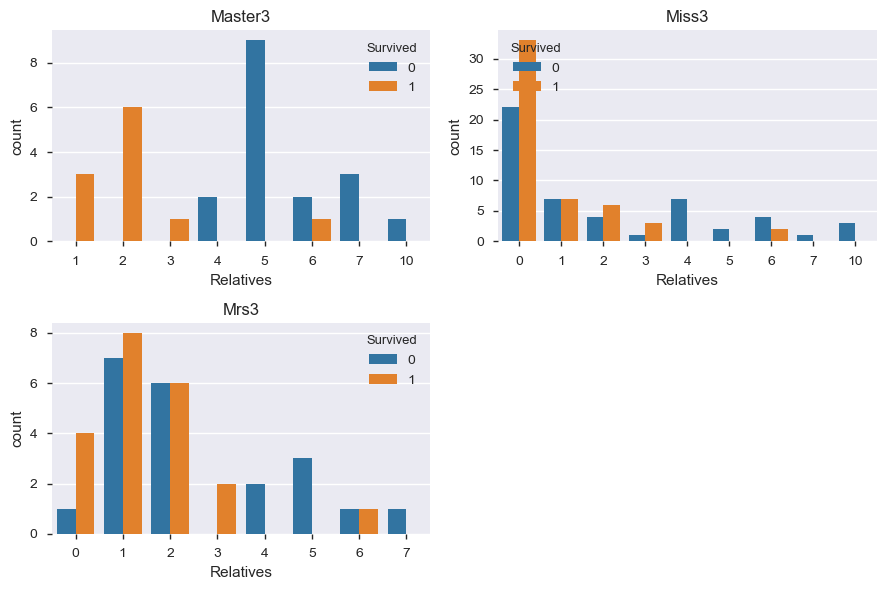

In [111]:
title_pclasses = ['Master3', 'Miss3', 'Mrs3']

fig = plt.figure(figsize=(9, 6))

for i, title_pclass in enumerate(title_pclasses, start=1):
    title_pclass_df = train_df[train_df['Title_Pclass'] == title_pclass]
    ax = fig.add_subplot(2, 2, i)
    sns.countplot(x='Relatives', hue='Survived', data=title_pclass_df, ax=ax)
    ax.set(title=title_pclass)

plt.tight_layout()

### Decision rule

In [112]:
def simple_decision_rule(row):
    if row['Title'] == 'Mr':
        return 0
    elif row['Pclass'] in [1, 2]:
        return 1
    elif row['Relatives'] >= 4:
        return 0
    else:
        return 1

In [113]:
y_pred = test_df.apply(simple_decision_rule, axis=1)
make_submission(y_pred, 'answers/answers2_simple_decision_rule.csv')

### Kagle accuracy score: 0.78947

# 3. Hybrid decision rule

In [114]:
X_train_indices = train_df[(train_df['Title_Pclass'] == 'Mr1') | (train_df['Title_Pclass'] == 'Miss3')
                        | (train_df['Title_Pclass'] == 'Mrs3')]['PassengerId']

X_test_indices = test_df[(test_df['Title_Pclass'] == 'Mr1') | (test_df['Title_Pclass'] == 'Miss3')
                        | (test_df['Title_Pclass'] == 'Mrs3')]['PassengerId']

full_df = pd.concat([train_df, test_df], axis=0)
full_df.drop(['Title_Pclass', 'Title', 'Sex', 'Pclass'], axis=1, inplace=True)

full_df = full_df[(full_df['PassengerId'].isin(X_train_indices)) | (full_df['PassengerId'].isin(X_test_indices))]
full_df = pd.get_dummies(full_df)

Train = full_df[full_df['PassengerId'].isin(X_train_indices)]
X_train = Train.drop(['PassengerId', 'Survived'], axis=1, inplace=False)
y_train = Train['Survived']

Test = full_df[full_df['PassengerId'].isin(X_test_indices)].copy()
X_test = Test.drop(['PassengerId', 'Survived'], axis=1, inplace=False)

print(X_train.shape)
print(X_test.shape)

(263, 8)
(127, 8)


In [115]:
def hybrid_decision_rule(row):
    if row['Title_Pclass'] in ['Mr2', 'Mr3']:
        return 0
    elif row['Title_Pclass'] in ['Master1', 'Master2', 'Miss1', 'Miss2', 'Mrs1', 'Mrs2']:
        return 1
    elif row['Title_Pclass'] == 'Master3':
        if row['Relatives'] >= 4:
            return 0
        else:
            return 1
    else:
        key_row = Test[Test['PassengerId'] == row['PassengerId']]
        if len(key_row) != 1:
            raise RuntimeError
        else:
            return key_row['Survived'].values[0]

In [116]:
random_forest = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=42)
random_forest.fit(X_train, y_train)

y_test = random_forest.predict(X_test)
Test['Survived'] = y_test

In [117]:
y_pred = test_df.apply(hybrid_decision_rule, axis=1)
make_submission(y_pred, 'answers/answers3_hybrid_decision_rule.csv')

### Kagle accuracy score: 0.77990

# 4. Decision tree

In [118]:
full_df = pd.concat([train_df, test_df], axis=0)
full_df.drop(['PassengerId'], axis=1, inplace=True)
full_df = pd.get_dummies(full_df)

X_train = full_df[:len(train_df)].drop(['Survived'], axis=1, inplace=False)
y_train = full_df[:len(train_df)]['Survived']
X_test = full_df[len(train_df):].drop(['Survived'], axis=1, inplace=False)

print(X_train.shape)
print(X_test.shape)

(891, 27)
(418, 27)


In [119]:
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
make_submission(y_pred, 'answers/answers4_single_decision_tree.csv')

In [120]:
export_graphviz(tree, feature_names=X_train.columns, out_file='decision_tree.dot')
!dot -Tpng 'decision_tree.dot' -o 'decision_tree.png'

<img src="decision_tree.png">

### Kagle accuracy score: 0.78947

# 5. XGBoost

In [121]:
full_df = pd.concat([train_df, test_df], axis=0)
full_df.drop(['PassengerId'], axis=1, inplace=True)
full_df = pd.get_dummies(full_df)

X_train = full_df[:len(train_df)].drop(['Survived'], axis=1, inplace=False)
y_train = full_df[:len(train_df)]['Survived']
X_test = full_df[len(train_df):].drop(['Survived'], axis=1, inplace=False)

print(X_train.shape)
print(X_test.shape)

(891, 27)
(418, 27)


### n_estimators for high learning_rate

In [122]:
def modelfit(params, X_train, y_train):
    
    xgb_train = xgb.DMatrix(X_train.values, label=y_train.values)
    cv_result = xgb.cv(params, xgb_train, num_boost_round=params['n_estimators'], nfold=5,
        metrics='error', early_stopping_rounds=50)
    
    params['n_estimators'] = cv_result.shape[0]
    print('n_estimators: ', cv_result.shape[0])
    
    xgb_clas = XGBClassifier(**params)
    xgb_clas.fit(X_train, y_train, eval_metric='error')
    
    y_train_pred = xgb_clas.predict(X_train)
    print('Train Accuracy: {:.4f}'.format(accuracy_score(y_train.values, y_train_pred)))

    feature_importances = pd.Series(xgb_clas.feature_importances_,
                                    index=X_train.columns).sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(10, 4))
    feature_importances.plot(kind='bar', title='Feature Importances', ax=ax)
    plt.ylabel('Feature Importances Score')

n_estimators:  92
Train Accuracy: 0.9226


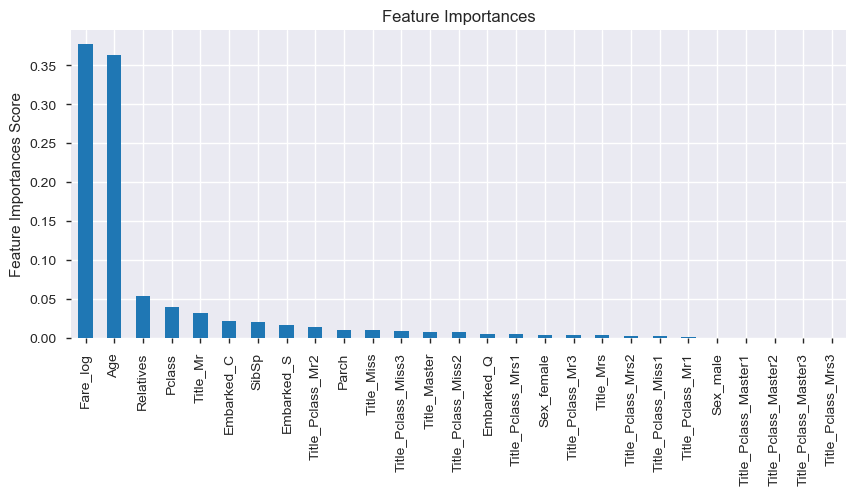

In [123]:
params = {'n_estimators': 1000,
          'learning_rate': 0.12,
          'max_depth': 5,
          'min_child_weight': 1,
          'random_state': 42}

modelfit(params, X_train, y_train)

### max_depth and min_child_weight

In [124]:
del params['max_depth']
del params['min_child_weight']

In [125]:
param_grid = {'max_depth': list(range(1, 8, 1)),
              'min_child_weight': list(range(1, 8, 1))}

xgb_clas = XGBClassifier(**params)
grid_search1 = GridSearchCV(xgb_clas, param_grid=param_grid, scoring='accuracy', n_jobs=-1, iid=False, cv=5)
grid_search1.fit(X_train, y_train)

print(grid_search1.best_score_)
print(grid_search1.best_params_)

0.848513699794
{'max_depth': 6, 'min_child_weight': 6}


In [126]:
params.update(grid_search1.best_params_)

### n_estimators for low learning_rate

In [127]:
params

{'learning_rate': 0.12,
 'max_depth': 6,
 'min_child_weight': 6,
 'n_estimators': 92,
 'random_state': 42}

In [128]:
params['learning_rate'] = 0.05
params['n_estimators'] = 1000

n_estimators:  43
Train Accuracy: 0.8631


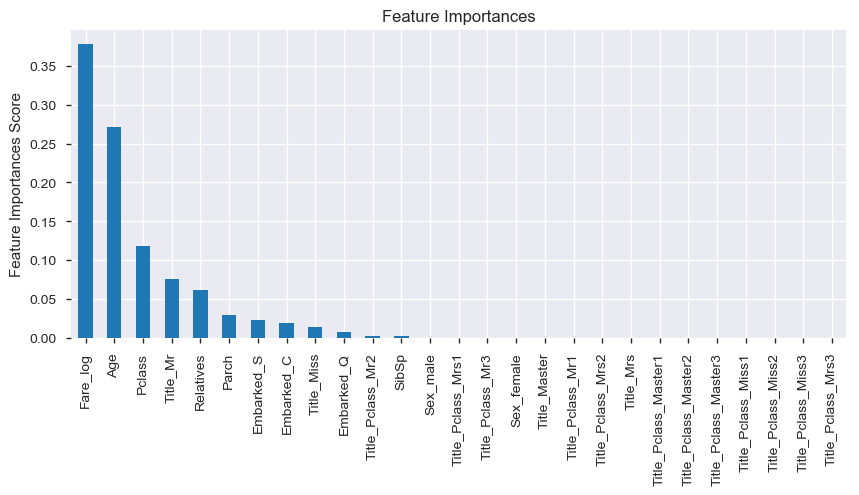

In [129]:
modelfit(params, X_train, y_train)

### XGBClassifier

In [130]:
params

{'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 6,
 'n_estimators': 43,
 'random_state': 42}

In [131]:
xgb_clas = XGBClassifier(**params)
xgb_clas.fit(X_train, y_train)

y_pred = xgb_clas.predict(X_test)
make_submission(y_pred, 'answers/answers5_xgboost.csv')

### Kagle accuracy score: 0.81818